<img style="float: right;" src="meetup_logo.svg" width=200>

# Meetup - Member Clustering

<i>Tools: Pandas, NLTK, Regex, KMeans, Matplotlib/Seaborn</i>

Use members' list of ```groups``` and ```interests``` to form optimal number of clusters using PCA and K-Means.

***

### 0. Import Libraries

In [1]:
# standard packages for analysis
import pandas as pd
import numpy as np

# NLP packages
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize, FreqDist
from nltk.stem import PorterStemmer
import string
import re

# modeling packages
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
# from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
sns.set_style('darkgrid')

# import helper functions
# from clustering_helpers.py import join_lists, process_string

# misc
import time
import pickle

### 1. Explore member profile data

In [2]:
# load all member_profiles datasets that were saved locally
# with open('member_profiles_16000.pkl', 'rb') as f:
#     member_profiles_16000 = pickle.load(f)
    
# with open('member_profiles_23000.pkl', 'rb') as f:
#     member_profiles_23000 = pickle.load(f)    
    
# with open('member_profiles_29001.pkl', 'rb') as f:
#     member_profiles_29001 = pickle.load(f)    
    
# with open('member_profiles_34001.pkl', 'rb') as f:
#     member_profiles_34001 = pickle.load(f)  
    
# save all_members
# with open('all_members_clustering.pickle', 'wb') as f:
#     pickle.dump(all_members, f)

In [3]:
# reload all_members
with open('all_members_clustering.pickle', 'rb') as f:
    all_members = pickle.load(f)

In [4]:
print(f'We will cluster {len(all_members):,} member profiles.')

We will cluster 32,974 member profiles.


In [5]:
# preview the data
df = pd.DataFrame(all_members)
df.head()

,groups,interests,member_url
0,"[Closing Deals in 6 Inch Heels NYC, Entreprene...","[Professional Development, Professional Women,...",http://www.meetup.com/members/57678912
1,"[Ann Arbor Web Accessibility, Data Driven NYC ...","[Adventure, Language & Culture, Nightlife, Bac...",http://www.meetup.com/members/230923603
2,"[ArtForward, Central Park Sketching & Art Meet...","[Theater, Performing Arts, Walking, Writing, A...",http://www.meetup.com/members/24427602
3,"[#Resist: Danbury, Adult Day Camp, Black Nonbe...","[Museum, Cooking Dinner Parties, Wine, Healthy...",http://www.meetup.com/members/75979532
4,['NYC- Small Business and Entrepreneurs Networ...,"[Hip Hop, Wine, Business Strategy, Dining Out,...",http://www.meetup.com/members/279891863


### 2. Preprocess text data

- Join `groups` and `interests` into a single text string
- Use regex to remove special characters from the single text string
- Temporarily turn the cleaned string to tokens to remove stopwords and perform stemming
- Re-join the cleaned & stemmed tokens into a single text string
- Vectorize the final text string using TF-IDF with a max feature of XXX

In [6]:
# function to join list of groups and interests into a single text string
def join_lists(row):
    return ' '.join(row['groups']+row['interests']).lower()

In [7]:
df['all_text'] = df.apply(join_lists, axis=1)

In [8]:
print("Text before processing:")
print("-----------------------")
df.all_text[100]

Text before processing:
-----------------------


"*amazing fairfield singles* greenwich young professionals group health 2.0 connecticut health 2.0 nyc - the nyc healthcare innovation group health innovators health technology forum: new york city tango and salsa in southern ct westchester flamenco ole! write yourself free wine expat brazilian whole food nutrition latin dance new immigrants career exploration doctors health professionals french language salsa investing self-improvement professional development work at home moms education & technology public speaking young professionals creative writing singles 30's-50's writing women's empowerment young professional women spirituality meditation artists musicians"

In [9]:
# create stopwords list; add punctuations to stopwords_list; add custom stopwords from freq_dist most common results
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['ct', 'learning','bay', 'jersey', 'thing','county', 'boston', 'brooklyn', 'york','meet', 'nyc','nj', 'ny','island','area','networking','san','new',"'s",'inc.','city','meetup','group','events', 'event', '``',"''",'things','user','etc','member', 've', 'manhattan']

In [10]:
# tokenizes, lemmatizes, removes stopwords
ps = PorterStemmer()

def process_string(row):
    regexed_text = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\\\]^_`{|}~0-9]+', '', row['all_text'])
    tokens = word_tokenize(regexed_text)
    stopped_tokens = [w.lower() for w in tokens if w not in stopwords_list]
    stemmed = [ps.stem(w) for w in stopped_tokens]
    final_tokens = [w for w in stemmed if w not in stopwords_list]
    return ' '.join(final_tokens)

In [11]:
# apply function to return a clean string
df['cleaned_string'] = df.apply(process_string,axis=1)

In [13]:
print("Text after processing:")
print("----------------------")
df['cleaned_string'][100]

Text after processing:
----------------------


'amaz fairfield singl greenwich young profession health connecticut health healthcar innov health innov health technolog forum tango salsa southern westchest flamenco ole write free wine expat brazilian whole food nutrit latin danc immigr career explor doctor health profession french languag salsa invest selfimprov profession develop work home mom educ technolog public speak young profession creativ write singl ss write women empower young profession women spiritu medit artist musician'

### 3. Vectorize the corpus

In [14]:
corpus = df['cleaned_string'].tolist()

In [15]:
tf_vectorizer = TfidfVectorizer(max_features = 250, ngram_range=(1,2))
tf_idf = tf_vectorizer.fit_transform(corpus)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

In [16]:
df_tfidf = pd.DataFrame(tf_idf_array, columns= tf_vectorizer.get_feature_names())
print(f'Length: {len(df_tfidf.columns)}')
print(f"\nList of all feature names ({len(df_tfidf.columns)})")
print("-------------------------------")
for c in df_tfidf.columns:
    print(c)

Length: 250

List of all feature names (250)
-------------------------------
act
activ
adventur
ai
altern
american
analyt
anim
architectur
art
artifici
artifici intellig
artist
asian
associ
bar
beauti
beer
beginn
big
big data
black
blockchain
board
book
book club
brunch
build
busi
busi strategi
circl
class
club
co
code
coffe
collabor
comedi
commun
commun skill
comput
comput program
connect
convers
cook
craft
creativ
creativ write
cultur
cultur exchang
danc
danc lesson
data
data scienc
date
date relationship
design
develop
digit
digit photographi
dine
dinner
discuss
diy
dog
draw
drink
drink talk
eat
eat drink
educ
educ technolog
empower
energi
engin
english
entertain
entrepreneur
entrepreneurship
estat
estat investor
exchang
exercis
experi
explor
fashion
fashion style
fiction
film
filmmak
fit
food
foodi
free
french
friend
fun
fun time
game
game night
gay
geek
girl
happi
happi hour
heal
health
healthi
healthi live
hike
hour
improv
indi
indian
industri
innov
intellectu
intellectu discuss


### 4. Find optimal clusters

In [19]:
# create kmeans cluster at varying size and get score
num_clusters = range(2, 500)
kmeans = [KMeans(n_clusters=i, max_iter = 300, random_state=100) for i in num_clusters]
score = [kmeans[i].fit(tf_idf_array).score(tf_idf_array) for i in range(len(kmeans))]

KeyboardInterrupt: 

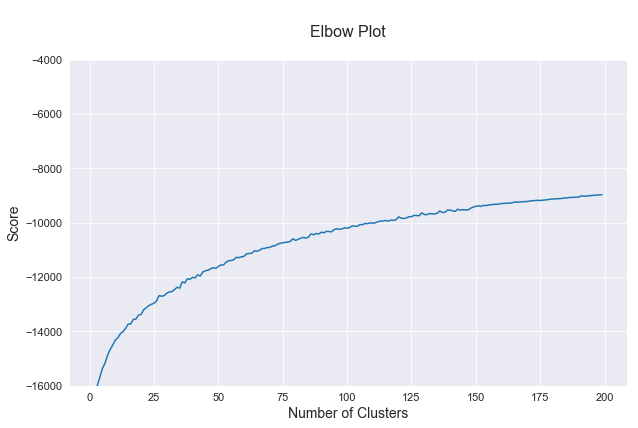

In [593]:
# plot score at varying number of clusters

plt.figure(figsize=(10,6))
plt.plot(num_clusters, score)
# plt.axvline(x=6, linewidth=1, color='r', linestyle='--')
# plt.text(6.5, -100, 'k=6', fontsize=14, style='italic')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Score',fontsize=14)
plt.ylim([-16000, -4000])
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('\nElbow Plot\n', fontsize=16)
plt.show() 

### 3. Final K-Means model

In [21]:
true_k = 50
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=400)
model.fit_transform(tf_idf_array)

print("Top terms per cluster:")
ordered_centroids = model.cluster_centers_.argsort()[:,::-1]
terms = tf_vectorizer.get_feature_names()

Top terms per cluster:


In [22]:
ordered_centroids

array([[202,  96, 103, ...,   3,  11,  10],
       [ 52,  20,  19, ...,   0, 130,  16],
       [245,  46,  47, ..., 174,   3,   6],
       ...,
       [130, 132, 100, ..., 140,  22,   3],
       [163,   2, 109, ...,   3,  80,  11],
       [137, 197, 202, ...,  10, 100,   3]])

In [24]:
cluster_label = list(range(len(ordered_centroids)))
top10_words = []

for i in range(len(ordered_centroids)):
    print("Cluster %d:" % i),
    per_centroid = []
    for ind in ordered_centroids[i, :10]:
        print(' %s' % terms[ind])
        per_centroid.append(terms[ind])
    top10_words.append(per_centroid)

# print(len(order_centroids))

Cluster 0:
 social
 fun
 happi
 happi hour
 hour
 adventur
 wine
 friend
 singl
 profession
Cluster 1:
 data
 big data
 big
 technolog
 analyt
 develop
 startup
 tech
 comput
 softwar
Cluster 2:
 write
 creativ
 creativ write
 writer
 book
 screenwrit
 art
 club
 workshop
 fiction
Cluster 3:
 sport
 recreat
 sport recreat
 outdoor
 fit
 co
 social
 exercis
 music
 well
Cluster 4:
 asian
 profession
 languag
 cultur
 social
 young
 singl
 american
 young profession
 art
Cluster 5:
 estat
 real estat
 real
 investor
 estat investor
 invest
 busi
 associ
 profession
 entrepreneur
Cluster 6:
 film
 filmmak
 video
 product
 indi
 industri
 screenwrit
 movi
 entertain
 art
Cluster 7:
 photographi
 travel
 digit photographi
 art
 digit
 music
 film
 fashion
 outdoor
 social
Cluster 8:
 gay
 men
 lgbt
 social
 friend
 profession
 cultur
 lesbian
 book
 singl
Cluster 9:
 technolog
 startup
 technolog startup
 mobil
 web
 busi
 educ
 develop
 web technolog
 tech
Cluster 10:
 drink
 eat
 eat drin

In [25]:
centroid_keywords = list(zip(cluster_label, top10_words))

In [26]:
centroid_keywords

[(0,
  ['social',
   'fun',
   'happi',
   'happi hour',
   'hour',
   'adventur',
   'wine',
   'friend',
   'singl',
   'profession']),
 (1,
  ['data',
   'big data',
   'big',
   'technolog',
   'analyt',
   'develop',
   'startup',
   'tech',
   'comput',
   'softwar']),
 (2,
  ['write',
   'creativ',
   'creativ write',
   'writer',
   'book',
   'screenwrit',
   'art',
   'club',
   'workshop',
   'fiction']),
 (3,
  ['sport',
   'recreat',
   'sport recreat',
   'outdoor',
   'fit',
   'co',
   'social',
   'exercis',
   'music',
   'well']),
 (4,
  ['asian',
   'profession',
   'languag',
   'cultur',
   'social',
   'young',
   'singl',
   'american',
   'young profession',
   'art']),
 (5,
  ['estat',
   'real estat',
   'real',
   'investor',
   'estat investor',
   'invest',
   'busi',
   'associ',
   'profession',
   'entrepreneur']),
 (6,
  ['film',
   'filmmak',
   'video',
   'product',
   'indi',
   'industri',
   'screenwrit',
   'movi',
   'entertain',
   'art']),
 (

In [46]:
df_cluster_keywords = pd.DataFrame(centroid_keywords, columns=['cluster_num', 'keywords'])

In [49]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
df_cluster_keywords.head()

,cluster_num,keywords
0,0,"[social, fun, happi, happi hour, hour, adventur, wine, friend, singl, profession]"
1,1,"[data, big data, big, technolog, analyt, develop, startup, tech, comput, softwar]"
2,2,"[write, creativ, creativ write, writer, book, screenwrit, art, club, workshop, fiction]"
3,3,"[sport, recreat, sport recreat, outdoor, fit, co, social, exercis, music, well]"
4,4,"[asian, profession, languag, cultur, social, young, singl, american, young profession, art]"


In [27]:
df_tfidf.head()

,act,activ,adventur,ai,altern,american,analyt,anim,architectur,art,...,wine,women,women empower,women social,workshop,write,writer,yoga,young,young profession
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.249797,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.089334,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.107674,0.086411,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.592671,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.213076,0.0,0.000000,0.0,0.0
3,0.0,0.075458,0.064070,0.0,0.0,0.0,0.0,0.094345,0.0,0.057697,...,0.231670,0.247893,0.102215,0.089185,0.081428,0.248916,0.0,0.089794,0.0,0.0
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.116485,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0


In [28]:
def get_vector(row):
    vector = []
    for c in df_tfidf.columns:
        vector.append(row[c])
    return vector

In [29]:
df_tfidf['tfidf_vector'] = df_tfidf.apply(get_vector, axis=1)

In [30]:
df_tfidf['tfidf_vector'].head()

0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    [0.0, 0.0, 0.08933449467614177, 0.0, 0.0, 0.0,...
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3    [0.0, 0.07545778428788974, 0.06406988854461645...
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: tfidf_vector, dtype: object

In [36]:
model.predict(np.array(df_tfidf['tfidf_vector'][0]).reshape(1,-1))

array([21], dtype=int32)

In [38]:
def get_prediction(row):
    prediction = model.predict(np.array(row['tfidf_vector']).reshape(1,-1))
    return prediction[0]

In [39]:
df_tfidf['cluster_group'] = df_tfidf.apply(get_prediction, axis=1)

In [42]:
df = pd.concat([df, df_tfidf['cluster_group']], axis=1)

In [44]:
pd.set_option('display.max_columns', None)
df.head()

,groups,interests,member_url,all_text,cleaned_string,cluster_group
0,"[Closing Deals in 6 Inch Heels NYC, Entreprene...","[Professional Development, Professional Women,...",http://www.meetup.com/members/57678912,closing deals in 6 inch heels nyc entrepreneur...,close deal inch heel entrepreneur busi startup...,21
1,"[Ann Arbor Web Accessibility, Data Driven NYC ...","[Adventure, Language & Culture, Nightlife, Bac...",http://www.meetup.com/members/230923603,ann arbor web accessibility data driven nyc (a...,ann arbor web access data driven firstmark ela...,40
2,"[ArtForward, Central Park Sketching & Art Meet...","[Theater, Performing Arts, Walking, Writing, A...",http://www.meetup.com/members/24427602,artforward central park sketching & art meetup...,artforward central park sketch art art book cl...,41
3,"[#Resist: Danbury, Adult Day Camp, Black Nonbe...","[Museum, Cooking Dinner Parties, Wine, Healthy...",http://www.meetup.com/members/75979532,#resist: danbury adult day camp black nonbelie...,resist danburi adult day camp black nonbeliev ...,29
4,['NYC- Small Business and Entrepreneurs Networ...,"[Hip Hop, Wine, Business Strategy, Dining Out,...",http://www.meetup.com/members/279891863,'nyc- small business and entrepreneurs network...,small busi entrepreneur black love travel fami...,10
